In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as oplgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import japanize_matplotlib

In [2]:
#このセルを実行すると保存したモデルを初期化します
Data = pd.read_csv(r"Dataset.csv",index_col=0,encoding="cp932")

In [3]:
models = {}

# 期間別時系列推移

In [4]:
# モード選択(Buy or Sell)
mode="Buy"
# 標準化
std_on=False

## データ前処理

- データはBuyとSell分析用に分けたあとそれぞれ上位1%を外れ値として除去
- 説明変数、被説明変数ともに標準化(平均：0，分散：1)
- 対象termを指定して期間を決定

In [5]:
if mode=="Buy":
    DataSetBuy = Data.drop(["ID", "ファンド名",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetBuy = DataSetBuy[DataSetBuy["設定額"]<DataSetBuy["設定額"].quantile(0.99)]
    
    #ここでtermを元データ(Data)から切り出しています
    # test_Data = DataSetBuy[DataSetBuy["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetBuy = DataSetBuy.loc[DataSetBuy[DataSetBuy["月"]=="2015/01"].index[0]\
                                :DataSetBuy[DataSetBuy["月"]=="2019/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetBuy.drop('設定額', axis=1)
    Y_train = DataSetBuy['設定額']
    
#     X_test = test_Data.drop('設定額', axis=1)
#     Y_test = test_Data['設定額']
    
    if std_on:
        #標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

    
elif mode=="Sell":
    DataSetSell = Data.drop(["ID", "ファンド名",\
                             "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetSell = DataSetSell[(DataSetSell["解約額"]<DataSetSell["解約額"].quantile(0.99))]
    
    #test_Data = DataSetSell[DataSetSell["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetSell = DataSetSell.loc[DataSetSell[DataSetSell["月"]=="2015/01"].index[0]\
                                  :DataSetSell[DataSetSell["月"]=="2019/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetSell.drop('解約額', axis=1)
    Y_train = DataSetSell['解約額']
    
#     X_test = test_Data.drop('解約額', axis=1)
#     Y_test = test_Data['解約額']
    
    if std_on:
        # 標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         Y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

else:
    print("Plese enter mode val 'Buy' or 'Sell'.")

## 学習（Optuna）

- 交差検証は10回行い、ハイパーパラメータを決定

In [6]:
# 訓練データ
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data = False)

kfold = KFold(n_splits=5,shuffle=True,random_state=0)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':0,
    "verbosity": -1
}

# Optunaでのパラメータ探索
tuner_cv = oplgb.LightGBMTunerCV(params, lgb_train, verbose_eval=-1,early_stopping_rounds=100,folds=kfold)

tuner_cv.run()

# 最適なパラメータの表示
best_params = tuner_cv.best_params
best_score = tuner_cv.best_score

test_size = 0.3  # 分割比率
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train, free_raw_data = False)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# 最適化パラメータで学習器構成
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test],early_stopping_rounds=100,verbose_eval=-1)
models[mode] = model

[I 2021-10-29 18:10:48,135] A new study created in memory with name: no-name-e03f1114-27a3-4688-9db2-b9ef720b71e2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026166:  14%|#4        | 1/7 [00:01<00:1

num_leaves, val_score: 0.026092:   5%|5         | 1/20 [00:03<01:08,  3.61s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.026092:  10%|#         | 2/20 [00:08<01:11,  3.99s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'e

num_leaves, val_score: 0.026092:  45%|####5     | 9/20 [00:32<00:43,  3.94s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.026092:  50%|#####     | 10/20 [00:35<00:36,  3.63s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: '

num_leaves, val_score: 0.026092:  85%|########5 | 17/20 [00:58<00:10,  3.59s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.026092:  90%|######### | 18/20 [00:59<00:05,  2.95s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 

bagging, val_score: 0.026081:  50%|#####     | 5/10 [00:08<00:08,  1.75s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.026081:  60%|######    | 6/10 [00:10<00:07,  1.94s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_s

feature_fraction_stage2, val_score: 0.026081:  50%|#####     | 3/6 [00:04<00:04,  1.54s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.026081:  67%|######6   | 4/6 [00:06<00:03,  1.68s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.026081:  20%|##        | 4/20 [00:07<00:29,  1.85s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.026081:  25%|##5       | 5/20 [00:09<00:26,  1.78s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.026038:  90%|######### | 18/20 [00:37<00:04,  2.25s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.026038:  95%|#########5| 19/20 [00:38<00:02,  2.02s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engi

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's rmse: 0.0271244


# 結果（Buy）

In [7]:
Buy_X = X_train
Buy_Y = Y_train
Buy_set = pd.concat([Buy_Y,Buy_X],axis=1,sort=False).reset_index(drop=True)
#Buy_set.to_csv()

In [8]:
#Buy all
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 8.125521819437923e-06,
 'lambda_l2': 0.0029773520940286867,
 'num_leaves': 31,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.9344242121178395,
 'bagging_freq': 1,
 'min_child_samples': 20}

In [9]:
pred_list_Buy = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Buy.append(nrmse_score)

Text(0, 0.5, 'pred')

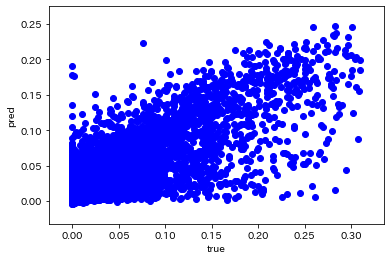

In [10]:
plt.scatter(Y_train, Y_pred,c='b')
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# 結果（Sell）

In [7]:
Sell_X = X_train
Sell_Y = Y_train
Sell_set = pd.concat([Sell_Y,Sell_X],axis=1,sort=False).reset_index(drop=True)
#Sell_set.to_csv()

In [8]:
# Sell
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 1.8847466786271963e-05,
 'lambda_l2': 1.1787256281854725e-08,
 'num_leaves': 62,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [11]:
pred_list_Sell = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Sell.append(nrmse_score)

Text(0, 0.5, 'pred')

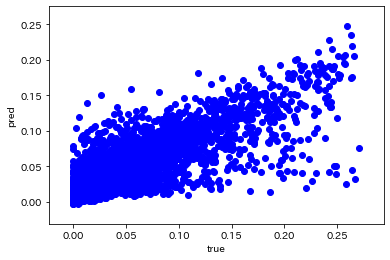

In [13]:
plt.scatter(Y_train, Y_pred,c='b');
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# SHAPley(Buy)

In [11]:
import shap
shap.initjs()

In [12]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(Buy_X,10000)
shap_v = explainer.shap_values(X=Buy_X)
Buy_shap_v = shap_v

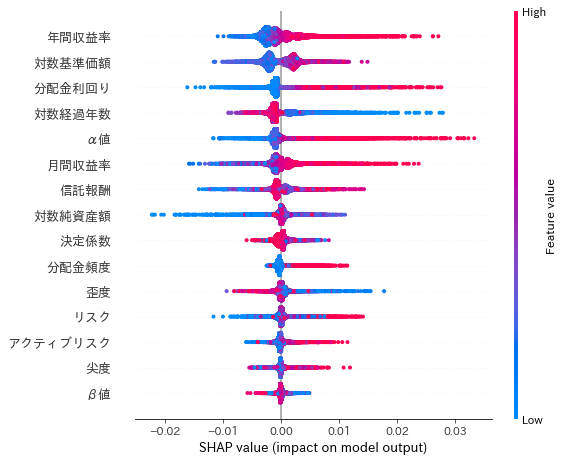

In [13]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

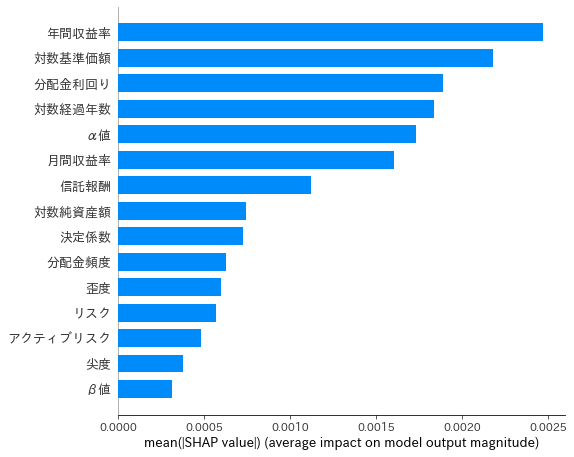

In [14]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,plot_type="bar",max_display=20)
# plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [15]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

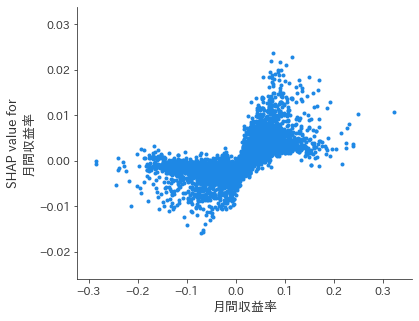

In [16]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '月間収益率', False)# 基準価額の値は対数変換されています

<Figure size 1080x1080 with 0 Axes>

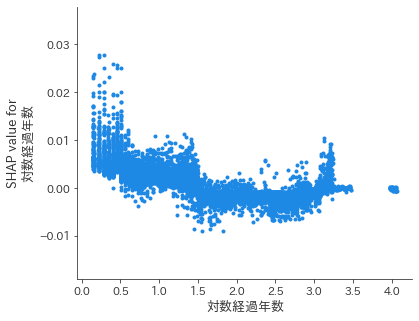

In [17]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

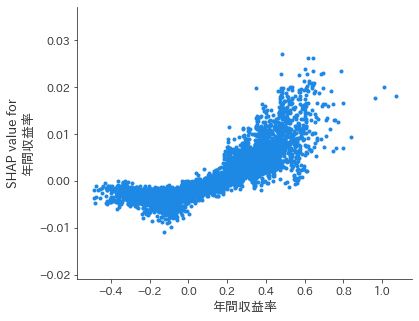

In [18]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '年間収益率', False)

<Figure size 1080x1080 with 0 Axes>

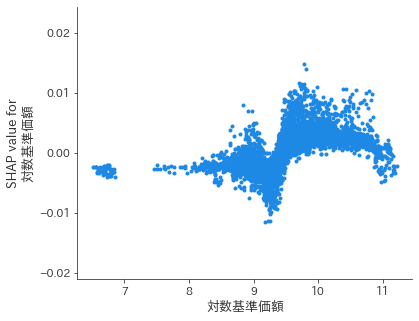

In [19]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

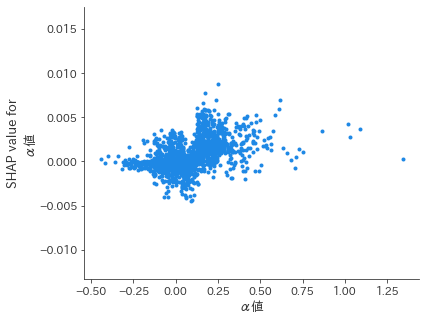

In [22]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'α値', False)

<Figure size 1080x1080 with 0 Axes>

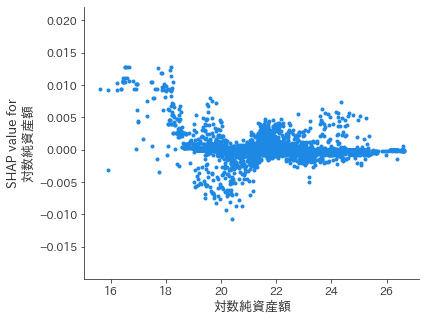

In [23]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数純資産額', False)

<Figure size 1080x1080 with 0 Axes>

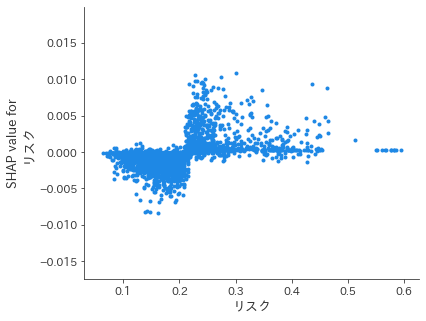

In [24]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'リスク',False)

<Figure size 1080x1080 with 0 Axes>

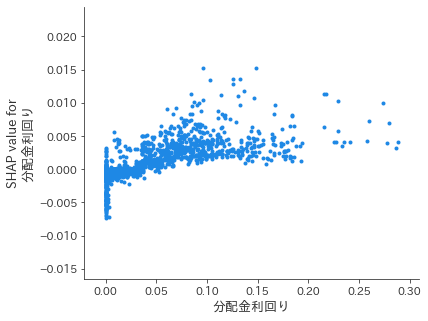

In [25]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '分配金利回り', False)

In [20]:
DF_Buy_shap = pd.DataFrame(Buy_shap_v,columns=Buy_X.columns[:])
DF_Buy_shap.to_csv("Buy_sv_term6.csv")

DF_Buy = pd.DataFrame(Buy_X,columns=Buy_X.columns[:])
DF_Buy.to_csv("Buy_term6.csv")

DF_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.009997,0.000047,0.001911,-0.000442,-0.000961,-0.000198,-0.000012,-3.610569e-04,-0.000955,-0.000894,-0.001034,0.000107,0.000517,0.000221,-0.000671,-0.000736
1,0.073084,0.000493,-0.004481,-0.002654,-0.001370,-0.000631,0.000374,-1.870614e-03,-0.007987,-0.004434,-0.001998,-0.002409,-0.002300,-0.005058,0.003699,-0.000183
2,-0.008732,-0.000128,-0.002281,-0.000906,-0.000809,-0.000060,0.000458,-9.394986e-05,-0.000778,-0.000791,-0.000740,0.000055,0.000085,-0.000273,-0.000829,-0.000376
3,-0.007895,0.000133,-0.002314,-0.001180,-0.000573,0.000110,0.000059,-1.400220e-05,-0.000733,-0.000412,-0.001063,-0.000178,-0.000576,-0.000256,0.000758,-0.000249
4,-0.002387,-0.000751,-0.003067,-0.000860,-0.001702,-0.000424,0.000018,-1.388528e-04,-0.001021,0.003624,-0.001053,0.000019,0.000109,-0.000454,-0.001653,-0.000858
5,-0.002808,0.000251,0.002068,-0.002196,0.002652,0.000191,0.000181,9.474948e-04,-0.001541,-0.001417,-0.000556,-0.000494,0.000563,-0.000763,0.000805,-0.000221
6,-0.002103,0.000821,0.000832,0.000351,0.002638,0.000815,0.000234,2.017417e-03,-0.002256,0.003766,-0.000946,-0.000519,0.000040,0.001143,-0.003546,0.000743
7,0.060344,0.001958,-0.000532,0.000620,0.003068,-0.002786,-0.002235,-1.940721e-03,-0.004805,0.006245,-0.001307,0.000090,-0.001360,-0.001353,-0.009581,-0.001404
8,0.012337,0.000939,0.001192,-0.000568,0.002667,0.000505,0.000295,3.006470e-04,-0.002132,0.003881,-0.001487,-0.000337,0.000123,0.001117,-0.002239,0.001279
9,-0.010652,0.001389,0.000960,-0.000440,0.000215,0.000478,-0.001065,-1.843674e-04,-0.002007,0.003020,-0.001160,0.000011,-0.000051,-0.000273,0.000571,-0.000110


#  

## 特定ファンド

In [21]:
target_data_term6 = pd.read_csv(r"/Users/chuudoutakuma/投信資金フロー/中道/for_nakamichi/プログラム/allterm/target_data_term6.csv",index_col=0)

In [22]:
target_Buy_X = target_data_term6.drop(["ID", "ファンド名","設定額","月",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Buy_Y = target_data_term6['設定額']
target_Buy_set = pd.concat([target_Buy_Y,target_Buy_X],axis=1,sort=False).reset_index(drop=True)

In [23]:
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(target_Buy_X,10000)
shap_v = explainer.shap_values(X=target_Buy_X)
Buy_shap_v = shap_v

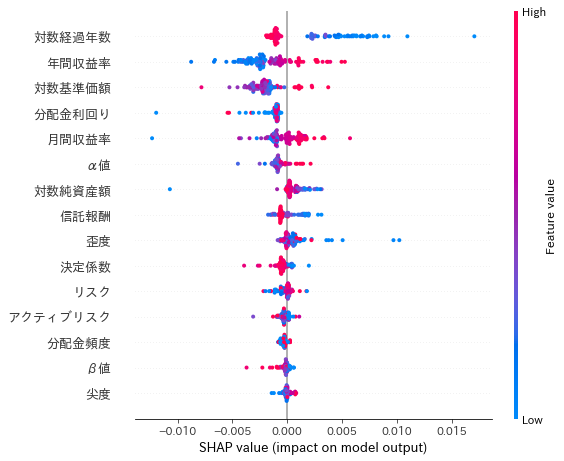

In [24]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=target_Buy_X.iloc[:,1:],feature_names=target_Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [25]:
DF_target_Buy_shap = pd.DataFrame(Buy_shap_v,columns=target_Buy_X.columns[:])
DF_target_Buy_shap.to_csv("target_Buy_sv_term6.csv")

DF_target_Buy = pd.DataFrame(target_Buy_X,columns=target_Buy_X.columns[:])
DF_target_Buy.to_csv("target_Buy_term6.csv")

DF_target_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.051291,-0.010708,-0.001637,0.005730,-0.008763,-0.000527,0.003572,0.000713,-0.003283,0.008162,-0.002516,-0.001578,0.000234,0.000761,-0.000335,-6.967327e-04
1,0.089151,0.001609,-0.002081,-0.001034,-0.003243,-0.002167,0.009692,-0.000062,-0.005309,0.007864,-0.000841,-0.000960,-0.001073,-0.001297,-0.001150,-7.761269e-04
2,0.088765,0.002766,-0.003275,0.000342,-0.004428,-0.001471,0.010228,0.000047,-0.005443,0.008100,-0.000800,-0.000935,-0.001512,-0.000983,-0.001745,-7.826687e-04
3,0.009500,0.001627,-0.001111,-0.001533,-0.003125,-0.000577,0.000791,-0.000010,-0.001104,0.005475,-0.001283,-0.000043,-0.000645,-0.000301,0.001812,-5.408488e-04
4,0.009791,-0.000067,-0.002168,0.000219,-0.004468,-0.000600,0.000518,0.000007,-0.000776,0.004681,-0.001313,-0.000081,-0.000550,-0.000249,0.001439,-5.376513e-04
5,-0.009291,0.001162,-0.002205,-0.000048,-0.003300,0.000121,0.000268,-0.000046,-0.001053,0.005528,-0.001120,0.000049,-0.000510,-0.000163,0.000640,-5.002620e-04
6,-0.010801,0.001463,-0.001308,-0.000815,-0.003060,0.000148,0.000817,-0.000200,-0.001094,0.005946,-0.000674,0.000035,-0.000620,-0.000226,0.001193,-3.755110e-04
7,-0.006395,0.000882,-0.002797,0.001673,-0.003830,0.000151,0.000542,-0.000128,-0.000832,0.003431,-0.001014,-0.000133,-0.000580,-0.000159,0.001379,-3.701494e-04
8,-0.011825,0.002074,-0.002723,0.001661,-0.001513,0.000304,0.001198,0.000554,-0.001069,0.004364,-0.001035,-0.000064,-0.000283,0.000184,0.001300,-3.622176e-04
9,0.048666,-0.000038,-0.005273,0.001581,-0.002296,0.000166,0.005057,-0.000110,-0.002073,0.004684,-0.004500,-0.003708,-0.001023,0.001099,-0.001463,-3.147921e-04


# SHAPley(Sell)

In [15]:
import shap
#plt.rcParams['font.family'] = "Yu Gothic"
shap.initjs()

In [18]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(Sell_X,10000)
shap_v = explainer.shap_values(X=Sell_X)
Sell_shap_v = shap_v

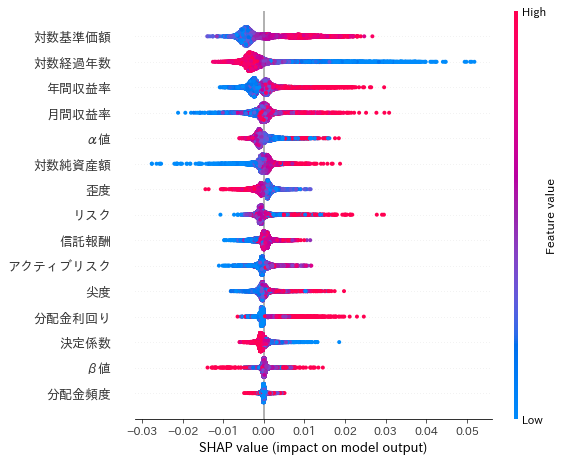

In [21]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

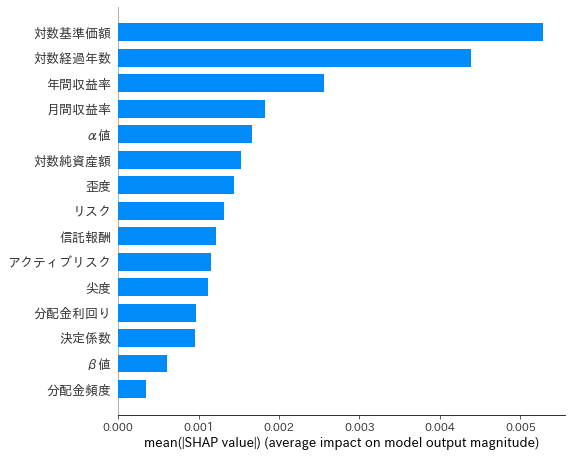

In [23]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20,plot_type="bar")
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [29]:
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

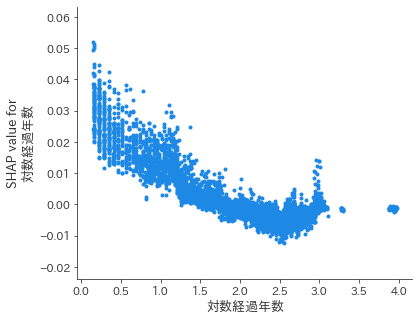

In [30]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

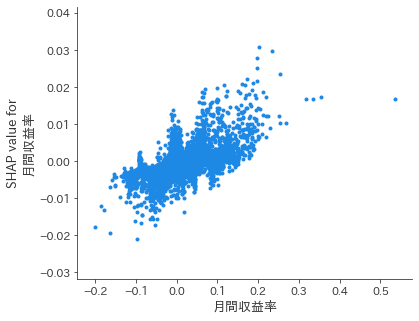

In [31]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

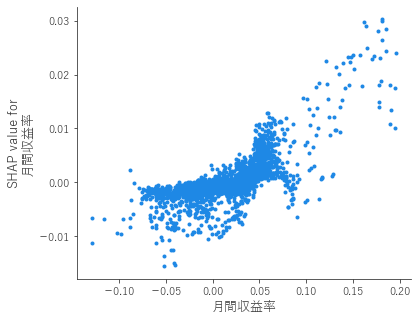

In [22]:
shap_plot(Sell_shap_v, X_test, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

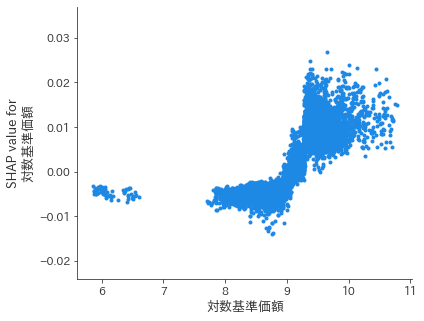

In [32]:
shap_plot(Sell_shap_v,Sell_X, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

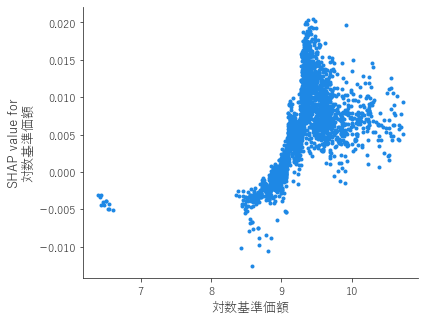

In [23]:
shap_plot(Sell_shap_v, X_test, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

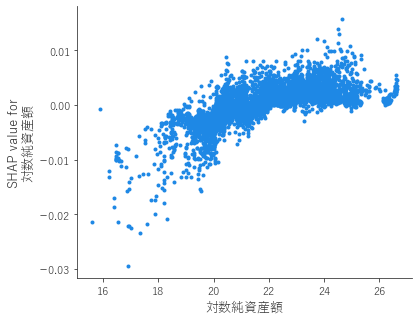

In [50]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数純資産額', True)

<Figure size 1080x1080 with 0 Axes>

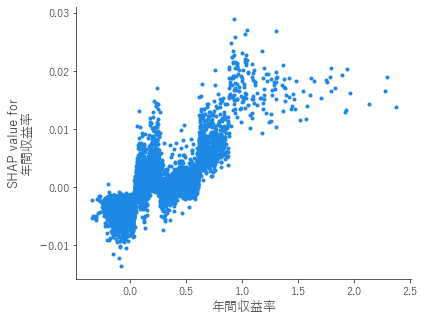

In [47]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

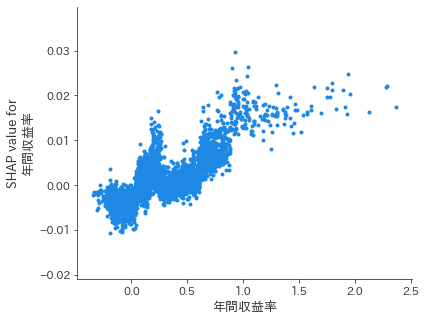

In [34]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

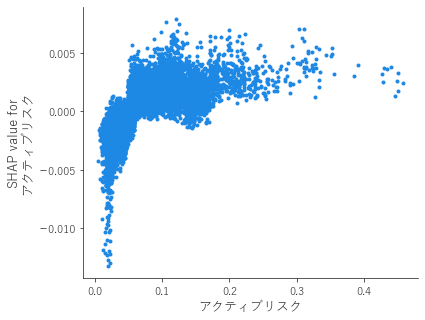

In [64]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'アクティブリスク', True)

<Figure size 1080x1080 with 0 Axes>

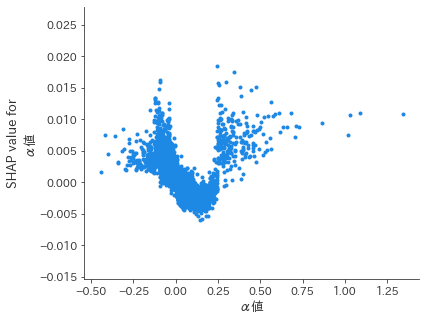

In [33]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

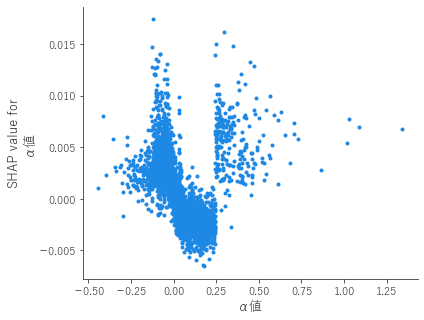

In [48]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

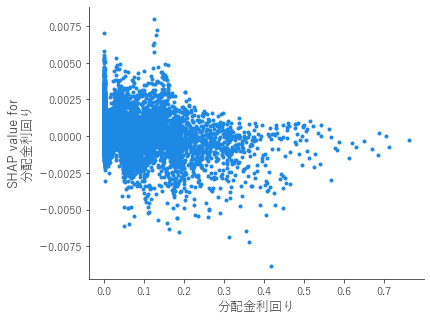

In [72]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '分配金利回り', False)

In [49]:
DF_Sell_shap = pd.DataFrame(Sell_shap_v,columns=Sell_X.columns[:])
DF_Sell_shap.to_csv()
DF_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.019862,-0.000201,-0.005300,0.002988,0.001431,-0.000462,-0.002683,-0.004216,-0.000591,-0.005013,-0.002524,0.000580,-0.000274,0.001818,0.002326,0.000230
1,0.022761,0.002025,-0.005464,-0.001104,0.000008,0.000147,0.000283,0.005095,-0.000676,0.014170,-0.000733,-0.000300,-0.000792,-0.000671,0.003361,0.000321
2,-0.005590,0.000781,-0.005542,-0.000166,0.000688,-0.000386,-0.000521,0.001728,-0.000501,-0.004101,-0.001097,0.000029,-0.000076,0.000204,0.000351,0.000155
3,-0.004679,-0.000085,-0.005819,-0.000309,0.000979,-0.000585,0.001262,-0.001125,-0.000398,-0.003099,-0.001718,0.000023,0.000393,0.001060,-0.000859,0.000430
4,-0.003119,0.002625,-0.004487,-0.000096,0.001360,-0.000722,-0.000177,-0.001432,-0.000406,-0.001344,-0.000871,0.000254,-0.000495,-0.001249,0.000404,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,0.020089,-0.000062,0.007273,0.002546,-0.004850,-0.001187,-0.001986,0.001336,-0.000159,-0.002462,0.002286,-0.001279,0.003151,-0.001548,-0.002860,-0.000228
11401,0.020520,0.000427,-0.006735,-0.001256,0.001205,-0.002090,-0.001415,0.005641,0.000047,-0.002750,0.001160,0.000853,0.005721,0.000720,0.000958,-0.000018
11402,0.044422,0.006032,0.022504,0.003597,0.007003,0.008174,0.005411,0.005479,0.001060,0.004584,0.012105,0.005634,0.011959,0.009664,0.003488,-0.000132
11403,0.035301,0.005905,0.016795,0.004753,-0.000307,-0.002053,0.000631,0.001531,0.000806,0.003226,0.006854,0.000907,-0.001123,-0.010146,0.000665,0.000505
